In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import glob

from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import (Input, Dense)
from smartula_analyze import save_to_file, is_affected

from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

Using TensorFlow backend.


## Load data to tuple list

In [2]:
audio_len = 1500

if os.name == "nt":
    path_name = "C:\\Users\\tymons\\001.Projects\\003.eul\\workspace\\smartula-analysis\\core\\csv\\"
else:
    path_name = "/home/tymons/Projects/003.eul/workspace/smartula-analysis/csv/"
    

all_filenames = [i for i in glob.glob(f"{path_name}*.csv")]
#all_filenames = all_filenames[:2]

list_of_audios = []
for filename in all_filenames:
    samples = pd.read_csv(filename, header=None).values[:audio_len].astype(float)
    samples = samples - samples.mean()
    samples = samples.reshape(samples.size)
    timestamp = filename.split(os.sep)[-1].split(".")[0]
    
    dict_sm = {"timestamp" : timestamp,
               "samples" : samples,
               "class" : is_affected(timestamp, [("2019-06-04T18-22-00", "2019-06-04T20-30-00"),
                                                ("2019-06-05T20-46-00", "2019-06-05T23-48-00"),
                                                ("2019-06-06T22-23-00", "2019-06-07T05-52-00")])}
           
    if len(samples) == audio_len:
        list_of_audios.append(dict_sm)
    else:
        print("Error with: " + filename +". Got length:" + str(samples.size))


Error with: C:\Users\tymons\001.Projects\003.eul\workspace\smartula-analysis\core\csv\2019-06-06T03-23-11.csv. Got length:1000
Error with: C:\Users\tymons\001.Projects\003.eul\workspace\smartula-analysis\core\csv\2019-06-07T03-09-11.csv. Got length:1000


## Model

In [43]:
encoding_dim = 32 

sound_input = Input(shape=(1500,))
encoded = Dense(784, activation='relu')(sound_input)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)
latent = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(64, activation='relu')(latent)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='relu')(decoded)
decoded = Dense(1500, activation='sigmoid')(decoded)

# this model maps an input to its reconstruction
autoencoder = Model(sound_input, decoded)
encoder = Model(sound_input, latent)

In [44]:
autoencoder.compile(optimizer='adadelta', loss='mse')

## Normalization and Standarization


In [45]:
k = 0.8

data = np.array([audio["samples"] for audio in list_of_audios])
data = preprocessing.scale(data)
data = preprocessing.normalize(data)

index = int(k*len(data))
x_train = data[:index]
x_test = data[index:]

In [46]:
es = [EarlyStopping(monitor='val_loss', min_delta=1e-05, patience=2)]

autoencoder.fit(x_train, x_train,
                epochs=500,
                shuffle=True,
                batch_size = 100,
                validation_data=(x_test, x_test),
                callbacks = es)


Train on 855 samples, validate on 214 samples
Epoch 1/500
855/855 [==============================] - 1s 855us/step - loss: 0.2498 - val_loss: 0.2500
Epoch 2/500
855/855 [==============================] - 0s 258us/step - loss: 0.2494 - val_loss: 0.2496
Epoch 3/500
855/855 [==============================] - 0s 252us/step - loss: 0.2490 - val_loss: 0.2493
Epoch 4/500
855/855 [==============================] - 0s 271us/step - loss: 0.2486 - val_loss: 0.2489
Epoch 5/500
855/855 [==============================] - 0s 272us/step - loss: 0.2482 - val_loss: 0.2485
Epoch 6/500
855/855 [==============================] - 0s 252us/step - loss: 0.2478 - val_loss: 0.2480
Epoch 7/500
855/855 [==============================] - 0s 244us/step - loss: 0.2474 - val_loss: 0.2476
Epoch 8/500
855/855 [==============================] - 0s 248us/step - loss: 0.2470 - val_loss: 0.2472
Epoch 9/500
855/855 [==============================] - 0s 244us/step - loss: 0.2466 - val_loss: 0.2468
Epoch 10/500
855/855 [=====

In [47]:
list_of_samples = np.array([audio_dict['samples'] for audio_dict in list_of_audios])
predictions = encoder.predict(list_of_samples)
classes = [audio_dict['class'] for audio_dict in list_of_audios]
colors = ["red" if category else "green" for category in classes]
pred_class_col = list(zip(predictions, classes, colors))

In [48]:
features_embedded = TSNE(n_components=2, perplexity=5, learning_rate=500, n_iter=2500, verbose=1) \
       .fit_transform([elem[0] for elem in pred_class_col])

features_class_col = list(zip(features_embedded, classes, colors, [audio["timestamp"] for audio in list_of_audios]))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 1069 samples in 0.003s...
[t-SNE] Computed neighbors for 1069 samples in 0.062s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1069
[t-SNE] Computed conditional probabilities for sample 1069 / 1069
[t-SNE] Mean sigma: 30.804982
[t-SNE] KL divergence after 250 iterations with early exaggeration: 84.465347
[t-SNE] KL divergence after 2500 iterations: 1.344856


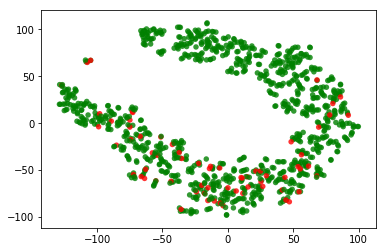

In [49]:
%matplotlib inline

# # Create plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for data, group, color, timestamp in features_class_col:
    x, y = data
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=str(group))
    
plt.show()


[(array([-32.41153 ,  69.287025], dtype=float32),
  False,
  'green',
  '2019-05-30T12-26-12'),
 (array([-88.471054, -54.35925 ], dtype=float32),
  False,
  'green',
  '2019-05-30T12-43-12')]

In [40]:
from bokeh.plotting import figure, show, output_file
from bokeh.models import ColumnDataSource

data_frame = pd.DataFrame()

np_features_class_col_t = np.asarray(features_class_col)

data_frame['colors'] = ["#003399" if group == True else "#ff0000" for group in np_features_class_col_t[:, 1]]
data_frame['timestamp'] = np_features_class_col_t[:, 3]
data_frame['group'] = np_features_class_col_t[:, 1]
data_frame['x'] = [point[0] for point in np_features_class_col_t[:, 0]]
data_frame['y'] = [point[1] for point in np_features_class_col_t[:, 0]]

source = ColumnDataSource(data=data_frame)

tools = "hover,pan,wheel_zoom,zoom_in,zoom_out,box_zoom,undo,redo,reset,tap,save,box_select," \
        "poly_select,lasso_select, "
tooltips = [
    ("timestamp", "@timestamp"),
    ("class", "@group")
]
p = figure(tools=tools, tooltips=tooltips)
p.scatter(x='x', y='y', fill_color='colors', fill_alpha=0.4, source=source, size=15, line_color=None)
output_file("color_scatter.html", title="color_scatter.py example")
show(p)  # open a browser

In [33]:
np_features_class_col_t[:2, 0]

array([array([-32.41153 ,  69.287025], dtype=float32),
       array([-88.471054, -54.35925 ], dtype=float32)], dtype=object)